### Individuazione dell'impulso negli esperimenti con materiale omogeneo, in particolare sul ferro. (No attenuazione?)
##### Prima picking sull'onda, direi che basta un sta/lta. Poi:
####  Misura della velocita' e della sua incertezza, data l'incertezza sul cammino percorso e sul picking 
#### attenuazione dell'ampiezza: studiare se e' solo geometrical spreading o anche
#### perdita delle alte frequenze

In [22]:
import json
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate, correlation_lags
from LAB_UW_functions import *
from math import ceil

In [23]:
def load_waveform_json(infile_path):
    with open(infile_path, "r") as json_file:
        data_dict = json.load(json_file)

    # Retrieve metadata and data from the loaded dictionary
    data = np.array(data_dict["data"])
    metadata = data_dict["metadata"]

    return data,metadata

def save_waveform_json(data , metadata, outfile_path):
    # Serialize pulse_metadata
    serialized_metadata = {key: serialize_value(value) for key, value in metadata.items()}

    # SAVE THE PULSE
    with open(outfile_path, "w") as output_json:
        # Create a dictionary to hold both metadata and data
        data_dict = {"metadata": serialized_metadata, "data": data.tolist()}

        # Save the dictionary to a JSON file
        json.dump(data_dict, output_json)


def serialize_value(value):
    '''
    Helper function to convert non-serializable values to serializable ones
    Needed to save numpy arrays in json file
    '''
    if isinstance(value, (np.ndarray, np.generic)):
        return value.tolist()
    elif isinstance(value, (np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64,
                             np.uint8, np.uint16, np.uint32, np.uint64)):
        return int(value)
    elif isinstance(value, (np.float_, np.float16, np.float32, np.float64)):
        return float(value)
    elif isinstance(value, (np.complex_, np.complex64, np.complex128)):
        return {"real": value.real, "imag": value.imag}
    elif isinstance(value, np.bool_):
        return bool(value)
    elif isinstance(value, (np.str_, np.string_)):
        return str(value)
    elif isinstance(value, (np.void)):
        return None
    else:
        return value
    

def sta_lta(waveform, sta_window, lta_window, energy=True):
    """
    Implements the STA/LTA algorithm on a 1D signal.

    Args:
    - signal: 1D numpy array representing the input signal.
    - sta_window: Length of the short-term average window (in samples).
    - lta_window: Length of the long-term average window (in samples).

    Returns:
    - A numpy array representing the STA/LTA ratio.
    """

    if energy:
        waveform = waveform**2      # do the sta/lta on the energy of the signal

    # Calculate STA (Short-Term Average)
    sta = np.convolve(np.abs(waveform), np.ones(sta_window), mode='same') / sta_window

    # Calculate LTA (Long-Term Average)
    lta = np.convolve(np.abs(waveform), np.ones(lta_window), mode='same') / lta_window

    # Calculate STA/LTA ratio
    sta_lta_ratio = sta / lta

    return sta_lta_ratio


def relative_argmax_given_known_numbers_of_them(waveform, chunk_n=5, offset=0, tolerance=0.1):
    """
    Find the relative argmax along with the minimums before and after the maximum within defined waveform chunks.

    Parameters:
    - waveform (array_like): The input waveform.
    - chunk_n (int, optional): Number of chunks to divide the waveform into. Default is 5.
    - offset (int, optional): Offset value to start indexing the waveform. Default is 0.
    - tolerance (float, optional): Tolerance value to consider when searching for minimums around the maximum.
                                   Default is 0.1.

    Returns:
    - index_max_list (list): List of indices of maximum values within each chunk.
    - index_min_before_list (list): List of indices of minimum values before each maximum within each chunk.
    - index_min_after_list (list): List of indices of minimum values after each maximum within each chunk.
    """

    chunk_len = ceil(len(waveform) / chunk_n)
    index_max_list = []
    index_min_before_list = []
    index_min_after_list = []

    for chunk in range(chunk_n):
        start = offset + chunk_len * chunk
        end = start + chunk_len
        chunk_max = np.amax(waveform[start:end])
        idx_chunk_max = np.argmax(waveform[start:end])

        # For each chunk, these are the absolute minimum before and after the maximum.
        chunk_min_before = np.amin(waveform[start:start + idx_chunk_max])
        idx_chunk_min_before = np.argmin(waveform[start:start + idx_chunk_max])

        chunk_min_after = np.amin(waveform[start + idx_chunk_max:end])
        idx_chunk_min_after = idx_chunk_max + np.argmin(waveform[start + idx_chunk_max:end])

        # Iteratively find minimums around the maximum considering a tolerance value.
        search_interval = idx_chunk_max - idx_chunk_min_before
        mask_wave = chunk_max * np.ones(len(waveform[start:end]))

        for idx in range(2, search_interval, 5):
            mask_wave[idx_chunk_max - idx:idx_chunk_max] = waveform[start + idx_chunk_max - idx:start + idx_chunk_max]
            difference = np.amin(mask_wave) - chunk_min_before
            if difference < tolerance:
                idx_chunk_min_before = np.argmin(mask_wave)
                break

        search_interval = idx_chunk_min_after - idx_chunk_max
        mask_wave = chunk_max * np.ones(len(waveform[start:end]))

        for idx in range(2, search_interval, 5):
            mask_wave[idx_chunk_max:idx_chunk_max + idx] = waveform[start + idx_chunk_max:start + idx_chunk_max + idx]
            difference = np.amin(mask_wave) - chunk_min_after
            if difference < tolerance:
                idx_chunk_min_after = np.argmin(mask_wave)
                break

        index_max = idx_chunk_max + start
        index_min_before = idx_chunk_min_before + start
        index_min_after = idx_chunk_min_after + start

        index_max_list.append(index_max)
        index_min_before_list.append(index_min_before)
        index_min_after_list.append(index_min_after)

    return index_max_list, index_min_before_list, index_min_after_list

def picking_plot(time,waveform,ratio, index_max_list, index_min_before_list, index_min_after_list, outfile_path):
    font_size = 30
    # Plot the data vs sta_lta picking
    fig = plt.figure(figsize=[16, 8])
    plt.plot(time, waveform, label='Waveform Recorded', alpha=0.5,linewidth=3.0)
    norm = (np.amax(waveform)/np.amax(ratio))
    plt.plot(time, norm*ratio, label='STA/LTA on Waveform')
    plt.plot(time[index_max_list], norm*ratio[index_max_list], "r.")
    plt.plot(time[index_min_before_list], norm*ratio[index_min_before_list], "g.")
    plt.plot(time[index_min_after_list], norm*ratio[index_min_after_list], "k.")
    plt.xticks(fontsize=0.7*font_size)
    plt.yticks(fontsize=0.7*font_size)
    plt.xlabel('Time [$\mu$s]',fontsize=0.7*font_size)
    plt.ylabel('Amplitude [a.u.]',fontsize=0.7*font_size)
    plt.legend(loc="lower left", fontsize=0.7*font_size)
#    plt.title("Measure the waveform in a homogenus space", fontsize=font_size)

    # output_path_choice(plot = plt, outfile_path=outfile_path, formato=formato)
#    plt.savefig(outfile_path)

#    plt.xlim([0, 90])



In [24]:

# Example usage of sta/lta
# Generate a synthetic signal and check the right sta_window and lta_window to maximize the ratio
# We already know the feature of the signal we want to see, and we can accordingly choose the sta/lta windows

nsamples = 1000
time = np.linspace(0, 10, nsamples)

noise_amplitude = 0.5
noise = np.random.normal(0, noise_amplitude, nsamples)

signal = np.zeros(noise.shape)

winlen = 100
square_start = 400
amp_square = 5
mask = amp_square * np.hanning(winlen)
signal[square_start:square_start+winlen] = mask

frequency = 4  # Hz
amplitude = 1
sin_signal = np.sin(2 * np.pi * frequency * time[square_start:square_start+winlen])
signal[square_start:square_start+winlen] =  mask * sin_signal

waveform = signal + noise


# Compute STA/LTA ratio
sta_window = 20        # best choice: twice the sinusoidal frequency
lta_window = 200       # best choice: twice the winlen of the hanning window

ratio = sta_lta(waveform, sta_window, lta_window)
index_max_list, index_min_before_list, index_min_after_list = relative_argmax_given_known_numbers_of_them(ratio, chunk_n=5, tolerance=1 )
outfile_path_pulse_EGU= "/home/michele/Desktop/Conferenza EGU 2024/sta_lta_picking.eps"
picking_plot(time, waveform,ratio, index_max_list, index_min_before_list, index_min_after_list, outfile_path=outfile_path_pulse_EGU)



TypeError: picking_plot() missing 1 required positional argument: 'outfile_path'

In [ ]:
# Try on real data

machine_name = "on_bench"
experiment_name = "glued_pzt"
data_type = "data_tsv_files"
# machine_name = "Brava_2"
# experiment_name = "s0098"
remove_initial_samples = 50    # number of samples to be removed at the beginning, to get rid of the noise burst.

infile_path_list = sorted(make_infile_path_list(machine_name,experiment_name, data_type=data_type))
infile_path = infile_path_list[3]

print(infile_path)   


/home/michele/Desktop/Dottorato/active_source_implementation/experiments_on_bench/glued_pzt/data_tsv_files/PIS1_PIS2_glued_100ns.bscan.tsv


PROCESSING UW DATA IN /home/michele/Desktop/Dottorato/active_source_implementation/experiments_on_bench/glued_pzt/data_tsv_files/PIS1_PIS2_glued_100ns.bscan.tsv: 


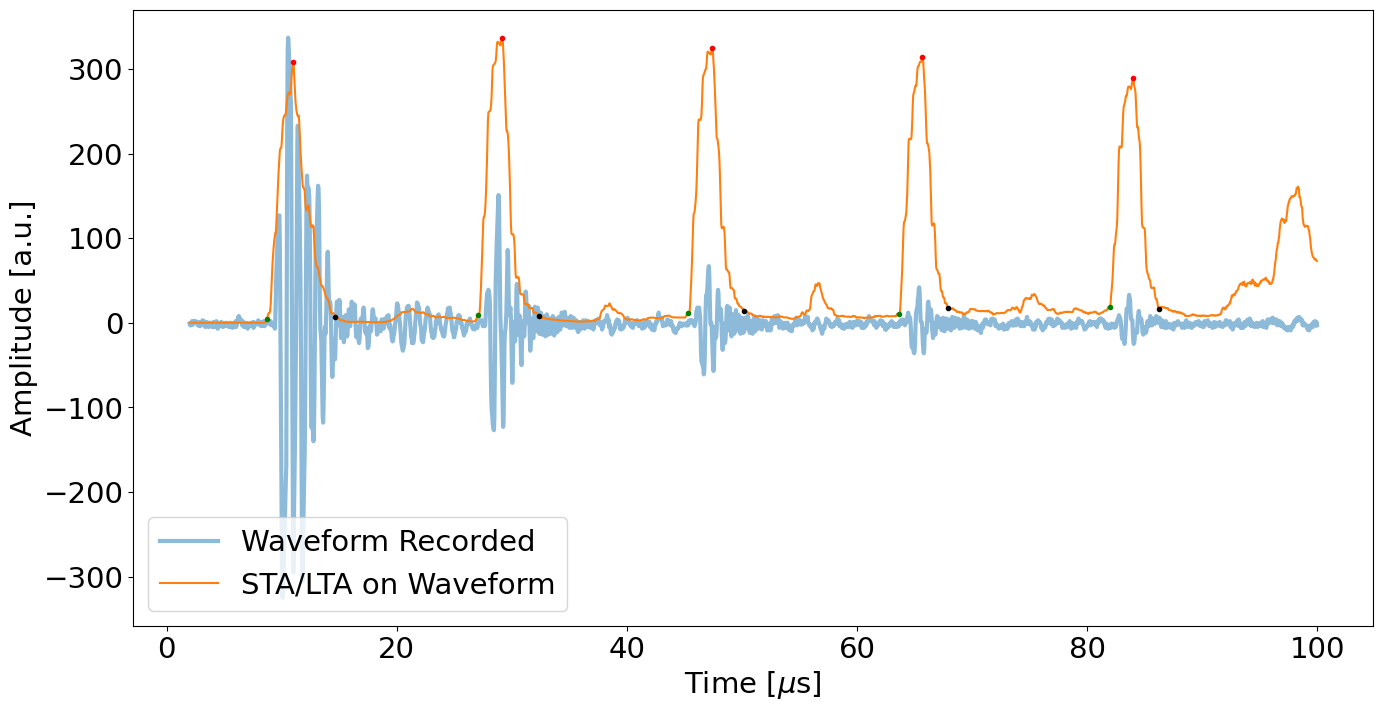

In [ ]:

# for infile_path in infile_path_list:
print('PROCESSING UW DATA IN %s: ' %infile_path)

data,metadata = make_UW_data(infile_path)
data,metadata = remove_starting_noise(data, metadata, remove_initial_samples)
x_ax = metadata['time_ax_waveform']

# windows must be:
sta_window = 2*ceil(1/ metadata['sampling_rate'])         # twice the number of samples of the pzt pulse that is, its resonance frequency
lta_window = 2*ceil(8/ metadata['sampling_rate'])         # twice the number of samples of the pulses train
number_of_pulse = 5                                       # it can be calculated by length of the sample and theoretical reasoning on velocity boundary

waveform = data[4,:]
# for waveform in data:
ratio = sta_lta(waveform, sta_window, lta_window)
index_max_list, index_min_before_list, index_min_after_list = relative_argmax_given_known_numbers_of_them(ratio, 
                                                                                                          chunk_n=number_of_pulse, 
                                                                                                          tolerance=0.2)
outfile_path_pulse_EGU= "/home/michele/Desktop/Conferenza EGU 2024/sta_lta_picking.eps"
picking_plot(x_ax, waveform,ratio, index_max_list, index_min_before_list, index_min_after_list, outfile_path=outfile_path_pulse_EGU)


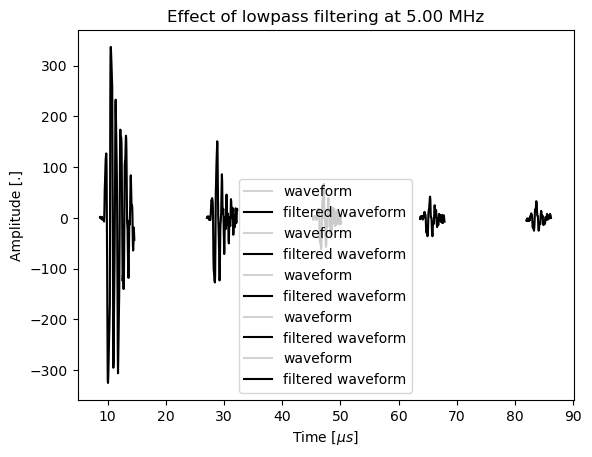

In [ ]:

# COLLECT THE PULSES WAVEFORM: they are going to be used in the forward modeling
data_type = ["pulses_from_glued_pzt"]
max_freq_machine_waveform = 5          # questo va studiato attraverso lo spettro effettivo!
outdir_path_data = make_data_analysis_folders(machine_name = machine_name, experiment_name=experiment_name, data_types=data_type)

for choosen_pulse in range(number_of_pulse):
    # CHOOSE THE FILE NAME WHERE TO SAVE WAVEFORMS AND THEIR METADATA 
    outfile_name = f"pulse_number_{choosen_pulse}"
    outfile_path = os.path.join(outdir_path_data[0],outfile_name)

    # DEFINE PULSE DATA
    start_pulse = index_min_before_list[choosen_pulse]
    end_pulse = index_min_after_list[choosen_pulse]
    pulse = waveform[start_pulse:end_pulse]

 
    # DEFINE PULSE METADATA: HEREDITATE METADATA AND UPDATE IT
    pulse_metadata = metadata.copy()         # copy is needed, otherwise both will point to the same memory!!!
    pulse_metadata['number_of_samples'] = len(pulse)
    pulse_metadata['number_of_waveforms'] = 1
    pulse_metadata['time_ax_waveform'] = metadata['time_ax_waveform'][start_pulse:end_pulse]
    pulse_metadata['maximum_frequency'] = max_freq_machine_waveform           # it is going import for forward modeling numerical stability

    # FILTER THE DATA AND SIGN IT IN THE METADATA
    # pulse_filtered, _ = signal2noise_separation_lowpass(waveform_data = pulse, metadata=pulse_metadata, 
    #                                                     freq_cut=max_freq_machine_waveform)
    # pulse_metadata['filtered'] = True


    save_waveform_json(data = pulse, metadata = pulse_metadata, outfile_path = outfile_path)



    signal_vs_filtered_signal_plot(single_waveform=pulse, single_waveform_filtered=pulse,
                                metadata=pulse_metadata, freq_cut=max_freq_machine_waveform)

 

        

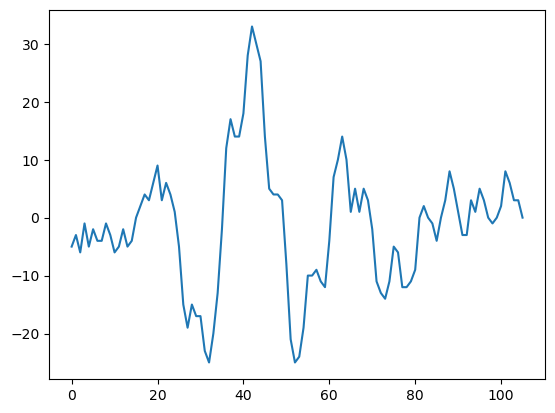

In [ ]:
 # Load data from JSON file
with open(outfile_path, "r") as json_file:
    data_dict = json.load(json_file)

# Retrieve metadata and data from the loaded dictionary
metadata = data_dict["metadata"]
data = np.array(data_dict["data"])

plt.plot(data)